A = 1.893932144874191e-17
Crossing at t = 2.98594889
x(t_cross) = 0.10000000
x'(t_cross) = 1.21243552


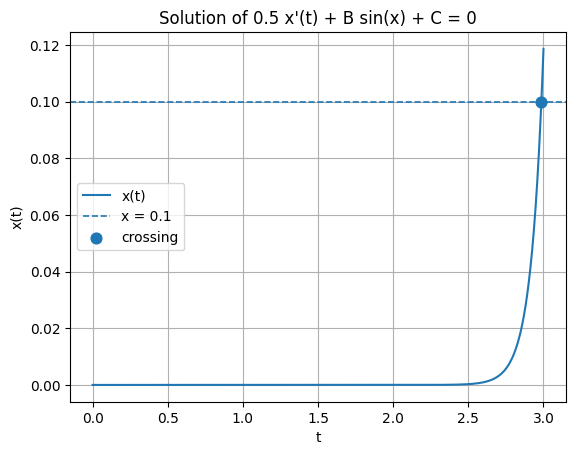

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def x_solution(t, A, B, x0=0.1, t0=0.0):
    """
    Your current placeholder solution.
    """
    t = np.asarray(t)
    return A * np.exp(B * t)

def x_prime(t, A, B):
    """Analytic derivative for the current x_solution."""
    t = np.asarray(t)
    return A * B * np.exp(B * t)

def find_crossing_time(x_func, x_target, t0, t1, *, A, B, num=50000):
    """
    Find the first time t in [t0, t1] such that x_func(t, A, B) = x_target.
    Uses a dense grid and linear interpolation between bracketing samples.
    """
    t = np.linspace(t0, t1, num)
    x = x_func(t, A, B)
    y = x - x_target

    # Indices where the sign changes (crossing)
    changes = np.where(np.signbit(y[:-1]) != np.signbit(y[1:]))[0]
    if changes.size == 0:
        raise ValueError("No crossing of x(t) = {} found on [{}, {}].".format(x_target, t0, t1))

    i = changes[0]
    t_lo, t_hi = t[i], t[i+1]
    x_lo, x_hi = x[i], x[i+1]

    # Linear interpolation to estimate crossing time
    t_cross = t_lo + (x_target - x_lo) * (t_hi - t_lo) / (x_hi - x_lo)

    # Sanity checks at the interpolated time
    x_cross = x_func(t_cross, A, B)
    xdot_cross = x_prime(t_cross, A, B)
    return t_cross, x_cross, xdot_cross

def plot_x_vs_t(B=0.5, C=1.0, x0=0.2, t0=0.0, t1=6.0, num=1000, x_target=0.1, A=1.0):
    """
    Plot x(t) over [t0, t1], draw a horizontal line at x = x_target,
    find and mark the first crossing, and print requested values.
    Note: uses the current x_solution(t; A, B).
    """
    t = np.linspace(t0, t1, num)
    x = x_solution(t, A, B, x0=x0, t0=t0)

    plt.figure()
    plt.plot(t, x, label="x(t)")
    plt.axhline(y=x_target, linestyle="--", linewidth=1.2, label=f"x = {x_target}")

    # Try to find crossing and mark it
    try:
        t_cross, x_cross, xdot_cross = find_crossing_time(x_solution, x_target, t0, t1, A=A, B=B)
        print(f"Crossing at t = {t_cross:.8f}")
        print(f"x(t_cross) = {x_cross:.8f}")
        print(f"x'(t_cross) = {xdot_cross:.8f}")
        plt.scatter([t_cross], [x_cross], s=60, zorder=5, label="crossing")
    except ValueError as e:
        print(str(e))

    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.title("Solution of 0.5 x'(t) + B sin(x) + C = 0")
    plt.grid(True)
    plt.legend()
    plt.show()

# ---------------- Constants & initial condition ----------------
g = 9.8
l = 0.1
hbar = 1.054_571_817e-34  # J·s
m = 0.1
B = np.sqrt(3 * g / (2*l))
theta0 = np.arccos(1 - 2*hbar/l**2)
dtheta0 = np.sqrt(2*hbar/l**2/m)
A = 0.5 * (theta0 + dtheta0 * 1/B)
print("A =", A)

# Important: your original call had parameter mixups.
# Here we pass A (amplitude) and B (growth rate) to the solution/plotter correctly.    ### <- This is what I solve for using small angle approximation, but ONLY valid for small angle
plot_x_vs_t(B=B, C=B, x0=0.1, t0=0.0, t1=3.0, num=800, x_target=0.1, A=A)


import numpy as np
import matplotlib.pyplot as plt

# ---------------- Existing placeholder solution ----------------
def x_solution(t, A, B, x0=0.1, t0=0.0):
    # Your current placeholder: x(t) = A * exp(B t)
    t = np.asarray(t)
    return A * np.exp(B * t)

def x_prime(t, A, B):
    # Analytic derivative: x'(t) = A * B * exp(B t)
    t = np.asarray(t)
    return A * B * np.exp(B * t)

def find_crossing_time(x_func, x_target, t0, t1, *, A, B, num=100000):
    """
    Find first time in [t0, t1] such that x_func(t) = x_target by
    dense sampling + linear interpolation between bracketing samples.
    """
    t = np.linspace(t0, t1, num)
    x = x_func(t, A, B)
    y = x - x_target
    changes = np.where(np.signbit(y[:-1]) != np.signbit(y[1:]))[0]
    if changes.size == 0:
        raise ValueError(f"No crossing of x(t) = {x_target} found on [{t0}, {t1}].")
    i = changes[0]
    t_lo, t_hi = t[i], t[i+1]
    x_lo, x_hi = x[i], x[i+1]
    t_cross = t_lo + (x_target - x_lo) * (t_hi - t_lo) / (x_hi - x_lo)
    return float(t_cross)

# ---------------- Second-order ODE: x'' = (3g/(2l)) * sin(x) ----------------
def rhs_second_order(t, y, g, l):
    """
    y = [x, v] where v = x'
    y' = [v, (3g/(2l)) * sin(x)]
    """
    x, v = y
    a = (3.0 * g / (2.0 * l)) * np.sin(x)
    return np.array([v, a])

def rk4_step(f, t, y, dt, *f_args):
    k1 = f(t,           y,             *f_args)
    k2 = f(t + 0.5*dt,  y + 0.5*dt*k1, *f_args)
    k3 = f(t + 0.5*dt,  y + 0.5*dt*k2, *f_args)
    k4 = f(t + dt,      y + dt*k3,     *f_args)
    return y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

def integrate_second_order(t_start, t_end, x0, v0, g, l, dt=1e-3):
    """
    Simple RK4 integrator for x'' = (3g/(2l)) * sin(x).
    Returns arrays T, X, V (including t_start).
    """
    n_steps = int(np.ceil((t_end - t_start)/dt))
    T = np.empty(n_steps + 1)
    X = np.empty(n_steps + 1)
    V = np.empty(n_steps + 1)

    T[0] = t_start
    X[0] = x0
    V[0] = v0
    y = np.array([x0, v0])

    t = t_start
    for i in range(1, n_steps + 1):
        y = rk4_step(rhs_second_order, t, y, dt, g, l)
        t = t_start + i*dt
        T[i] = t
        X[i] = y[0]
        V[i] = y[1]
    return T, X, V

def find_level_time(T, X, level):
    """
    Find first time T* such that X crosses 'level' (linear interpolation).
    Returns None if no crossing.
    """
    Y = X - level
    changes = np.where(np.signbit(Y[:-1]) != np.signbit(Y[1:]))[0]
    if changes.size == 0:
        return None
    i = changes[0]
    t_lo, t_hi = T[i], T[i+1]
    x_lo, x_hi = X[i], X[i+1]
    return float(t_lo + (level - x_lo) * (t_hi - t_lo) / (x_hi - x_lo))

# ---------------- High-level routine that does everything ----------------
def run_all_and_plot(
    *, 
    g=9.8, l=0.1, 
    A=1.0, B=1.0, 
    t0=0.0, t1=3.0, num=2000, 
    x_target_first=0.1, 
    extra_seconds=2.0, 
    dt=1e-3
):
    # 1) Original analytic segment
    t_anal = np.linspace(t0, t1, num)
    x_anal = x_solution(t_anal, A, B, x0=x_target_first, t0=t0)

    # 2) Find t_{0.1} and x'(t_{0.1})
    t_cross_01 = find_crossing_time(x_solution, x_target_first, t0, t1, A=A, B=B)
    x_at_cross  = x_solution(t_cross_01, A, B)
    v_at_cross  = x_prime(t_cross_01, A, B)

    print(f"[Stage 1] First crossing of x = {x_target_first}:")
    print(f"  t_0.1        = {t_cross_01:.8f}")
    print(f"  x(t_0.1)     = {x_at_cross:.8f}")
    print(f"  x'(t_0.1)    = {v_at_cross:.8f}")

    # 3) Integrate second-order ODE from t_cross_01 for +2 seconds
    T_num, X_num, V_num = integrate_second_order(
        t_start=t_cross_01,
        t_end=t_cross_01 + extra_seconds,
        x0=x_at_cross,
        v0=v_at_cross,
        g=g, l=l, dt=dt
    )

    # 4) Find time where x = pi/2 during the new segment
    level = np.pi/2
    t_pi2_num = find_level_time(T_num, X_num, level)

    if t_pi2_num is not None:
        print(f"[Stage 2] Crossing x = pi/2 in the numeric segment at t = {t_pi2_num:.8f}")
    else:
        print("[Stage 2] No crossing of x = pi/2 in the numeric segment.")

    # 5) Plot: numeric segment with horizontal x = pi/2
    plt.figure()
    plt.plot(T_num, X_num, label="x(t) (numeric, 2s continuation)")
    plt.axhline(level, linestyle="--", linewidth=1.2, label="x = pi/2")
    if t_pi2_num is not None:
        x_at_pi2 = level
        plt.scatter([t_pi2_num], [x_at_pi2], s=60, zorder=5, label="x = pi/2 crossing")
        plt.annotate(f"t = {t_pi2_num:.4f}", (t_pi2_num, x_at_pi2),
                     textcoords="offset points", xytext=(6, 8))
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.title("Numeric evolution (from t_0.1 for +2 s)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 6) Combined plot: original analytic segment + numeric continuation
    # Use analytic up to (but not beyond) t_cross_01 to avoid duplicate time points.
    mask_up_to_cross = t_anal <= t_cross_01
    T_full = np.concatenate([t_anal[mask_up_to_cross], T_num])
    X_full = np.concatenate([x_anal[mask_up_to_cross], X_num])

    plt.figure()
    plt.plot(T_full, X_full, label="x(t) (analytic ⟶ numeric)")
    plt.axhline(level, linestyle="--", linewidth=1.2, label="x = pi/2")

    # Mark pi/2 crossing if it exists (same time index as numeric seg)
    if t_pi2_num is not None:
        plt.scatter([t_pi2_num], [level], s=60, zorder=5, label="x = pi/2 crossing")
        plt.annotate(f"t = {t_pi2_num:.4f}", (t_pi2_num, level),
                     textcoords="offset points", xytext=(6, 8))

    # Also (optionally) show the original x=0.1 crossing point on the combined plot
    plt.scatter([t_cross_01], [x_at_cross], s=40, zorder=5, label="x = 0.1 (join)")

    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.title("Full time evolution with horizontal line at x = pi/2")
    plt.grid(True)
    plt.legend()
    plt.show()

# ---------------- Example usage with your constants ----------------
g = 9.8
l = 0.1
hbar = 1.054_571_817e-34  # J·s
m = 0.1

# From your earlier definitions
B = np.sqrt(3 * g / (2*l))
theta0 = np.arccos(1 - 2*hbar/l**2)
dtheta0 = np.sqrt(2*hbar/l**2/m)
A = 0.5 * (theta0 + dtheta0 * 1/B)

# Run: original analytic over [0, 3s], then numeric +2s, plots as requested.
run_all_and_plot(g=g, l=l, A=A, B=B, t0=0.0, t1=3, num=1200, x_target_first=0.1,
                 extra_seconds=0.5, dt=1e-3)


[Stage 1] First crossing of x = 0.1:
  t_0.1        = 2.98594889
  x(t_0.1)     = 0.10000000
  x'(t_0.1)    = 1.21243555
[Stage 2] Crossing x = pi/2 in the numeric segment at t = 3.21747259


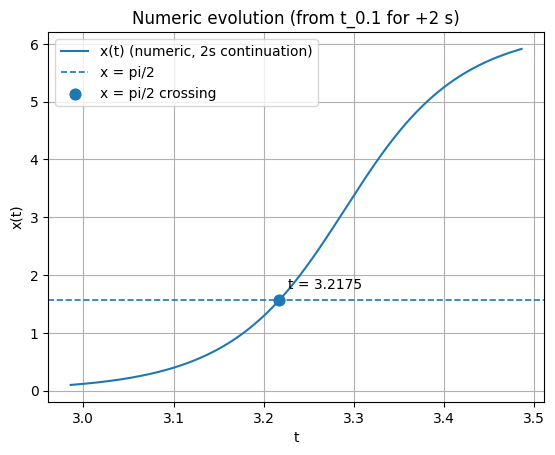

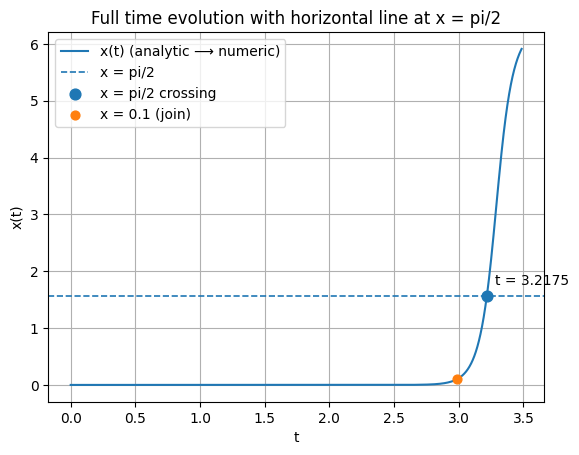

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Existing placeholder solution ----------------
def x_solution(t, A, B, x0=0.1, t0=0.0):
    # Your current placeholder: x(t) = A * exp(B t)
    t = np.asarray(t)
    return A * np.exp(B * t)

def x_prime(t, A, B):
    # Analytic derivative: x'(t) = A * B * exp(B t)
    t = np.asarray(t)
    return A * B * np.exp(B * t)

def find_crossing_time(x_func, x_target, t0, t1, *, A, B, num=100000):
    """
    Find first time in [t0, t1] such that x_func(t) = x_target by
    dense sampling + linear interpolation between bracketing samples.
    """
    t = np.linspace(t0, t1, num)
    x = x_func(t, A, B)
    y = x - x_target
    changes = np.where(np.signbit(y[:-1]) != np.signbit(y[1:]))[0]
    if changes.size == 0:
        raise ValueError(f"No crossing of x(t) = {x_target} found on [{t0}, {t1}].")
    i = changes[0]
    t_lo, t_hi = t[i], t[i+1]
    x_lo, x_hi = x[i], x[i+1]
    t_cross = t_lo + (x_target - x_lo) * (t_hi - t_lo) / (x_hi - x_lo)
    return float(t_cross)

# ---------------- Second-order ODE: x'' = (3g/(2l)) * sin(x) ----------------
def rhs_second_order(t, y, g, l):
    """
    y = [x, v] where v = x'
    y' = [v, (3g/(2l)) * sin(x)]
    """
    x, v = y
    a = (3.0 * g / (2.0 * l)) * np.sin(x)
    return np.array([v, a])

def rk4_step(f, t, y, dt, *f_args):
    k1 = f(t,           y,             *f_args)
    k2 = f(t + 0.5*dt,  y + 0.5*dt*k1, *f_args)
    k3 = f(t + 0.5*dt,  y + 0.5*dt*k2, *f_args)
    k4 = f(t + dt,      y + dt*k3,     *f_args)
    return y + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)

def integrate_second_order(t_start, t_end, x0, v0, g, l, dt=1e-3):
    """
    Simple RK4 integrator for x'' = (3g/(2l)) * sin(x).
    Returns arrays T, X, V (including t_start).
    """
    n_steps = int(np.ceil((t_end - t_start)/dt))
    T = np.empty(n_steps + 1)
    X = np.empty(n_steps + 1)
    V = np.empty(n_steps + 1)

    T[0] = t_start
    X[0] = x0
    V[0] = v0
    y = np.array([x0, v0])

    t = t_start
    for i in range(1, n_steps + 1):
        y = rk4_step(rhs_second_order, t, y, dt, g, l)
        t = t_start + i*dt
        T[i] = t
        X[i] = y[0]
        V[i] = y[1]
    return T, X, V

def find_level_time(T, X, level):
    """
    Find first time T* such that X crosses 'level' (linear interpolation).
    Returns None if no crossing.
    """
    Y = X - level
    changes = np.where(np.signbit(Y[:-1]) != np.signbit(Y[1:]))[0]
    if changes.size == 0:
        return None
    i = changes[0]
    t_lo, t_hi = T[i], T[i+1]
    x_lo, x_hi = X[i], X[i+1]
    return float(t_lo + (level - x_lo) * (t_hi - t_lo) / (x_hi - x_lo))

# ---------------- High-level routine that does everything ----------------
def run_all_and_plot(
    *, 
    g=9.8, l=0.1, 
    A=1.0, B=1.0, 
    t0=0.0, t1=3.0, num=2000, 
    x_target_first=0.1, 
    extra_seconds=2.0, 
    dt=1e-3
):
    # 1) Original analytic segment
    t_anal = np.linspace(t0, t1, num)
    x_anal = x_solution(t_anal, A, B, x0=x_target_first, t0=t0)

    # 2) Find t_{0.1} and x'(t_{0.1})
    t_cross_01 = find_crossing_time(x_solution, x_target_first, t0, t1, A=A, B=B)
    x_at_cross  = x_solution(t_cross_01, A, B)
    v_at_cross  = x_prime(t_cross_01, A, B)

    print(f"[Stage 1] First crossing of x = {x_target_first}:")
    print(f"  t_0.1        = {t_cross_01:.8f}")
    print(f"  x(t_0.1)     = {x_at_cross:.8f}")
    print(f"  x'(t_0.1)    = {v_at_cross:.8f}")

    # 3) Integrate second-order ODE from t_cross_01 for +2 seconds
    T_num, X_num, V_num = integrate_second_order(
        t_start=t_cross_01,
        t_end=t_cross_01 + extra_seconds,
        x0=x_at_cross,
        v0=v_at_cross,
        g=g, l=l, dt=dt
    )

    # 4) Find time where x = pi/2 during the new segment
    level = np.pi/2
    t_pi2_num = find_level_time(T_num, X_num, level)

    if t_pi2_num is not None:
        print(f"[Stage 2] Crossing x = pi/2 in the numeric segment at t = {t_pi2_num:.8f}")
    else:
        print("[Stage 2] No crossing of x = pi/2 in the numeric segment.")

    # 5) Plot: numeric segment with horizontal x = pi/2
    plt.figure()
    plt.plot(T_num, X_num, label="x(t) (numeric, 2s continuation)")
    plt.axhline(level, linestyle="--", linewidth=1.2, label="x = pi/2")
    if t_pi2_num is not None:
        x_at_pi2 = level
        plt.scatter([t_pi2_num], [x_at_pi2], s=60, zorder=5, label="x = pi/2 crossing")
        plt.annotate(f"t = {t_pi2_num:.4f}", (t_pi2_num, x_at_pi2),
                     textcoords="offset points", xytext=(6, 8))
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.title("Numeric evolution (from t_0.1 for +2 s)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 6) Combined plot: original analytic segment + numeric continuation
    # Use analytic up to (but not beyond) t_cross_01 to avoid duplicate time points.
    mask_up_to_cross = t_anal <= t_cross_01
    T_full = np.concatenate([t_anal[mask_up_to_cross], T_num])
    X_full = np.concatenate([x_anal[mask_up_to_cross], X_num])

    plt.figure()
    plt.plot(T_full, X_full, label="x(t) (analytic ⟶ numeric)")
    plt.axhline(level, linestyle="--", linewidth=1.2, label="x = pi/2")

    # Mark pi/2 crossing if it exists (same time index as numeric seg)
    if t_pi2_num is not None:
        plt.scatter([t_pi2_num], [level], s=60, zorder=5, label="x = pi/2 crossing")
        plt.annotate(f"t = {t_pi2_num:.4f}", (t_pi2_num, level),
                     textcoords="offset points", xytext=(6, 8))

    # Also (optionally) show the original x=0.1 crossing point on the combined plot
    plt.scatter([t_cross_01], [x_at_cross], s=40, zorder=5, label="x = 0.1 (join)")

    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.title("Full time evolution with horizontal line at x = pi/2")
    plt.grid(True)
    plt.legend()
    plt.show()

# ---------------- Example usage with your constants ----------------
g = 9.8
l = 0.1
hbar = 1.054_571_817e-34  # J·s
m = 0.1

# From your earlier definitions
B = np.sqrt(3 * g / (2*l))
theta0 = np.arccos(1 - 2*hbar/l**2)
dtheta0 = np.sqrt(2*hbar/l**2/m)
A = 0.5 * (theta0 + dtheta0 * 1/B)

# Run: original analytic over [0, 3s], then numeric +2s, plots as requested.
run_all_and_plot(g=g, l=l, A=A, B=B, t0=0.0, t1=3, num=1200, x_target_first=0.1,
                 extra_seconds=0.5, dt=1e-3)
